In [1]:
import pandas as pd 
import numpy as np
import copy 
import random
from matplotlib import pyplot as plt 
from glob import glob
import re
import nltk
from numpy.linalg import norm
from scipy.spatial.distance import pdist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stop = stopwords.words('english')
from nltk import pos_tag
import scipy.cluster.hierarchy as sch

In [2]:
rawdata = "/Users/Christine/Library/Mobile Documents/com~apple~CloudDocs/Patent/rawdata"
workdata = "/Users/Christine/Library/Mobile Documents/com~apple~CloudDocs/Patent/workdata"
results = "/Users/Christine/Library/Mobile Documents/com~apple~CloudDocs/Patent/results"

In [34]:
pooling_patent_data = pd.read_csv(f'{workdata}/pooling_patent_data_filter.csv')
pooling_patent_data

,Patent_ID,Patent_abstract,cleaned_and_stemmed_nouns_verbs_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...,patent medicin form capsul is prepar chiretta ...
1,CN200710126165.3,The invention discloses a method and apparatus...,invent disclos method apparatu hide data packa...
2,CN200610060717.0,The method comprises: receiving an audio signa...,method compris receiv signal signal sourc get ...
3,CN00103340.9,A device for eliminating the mini ice crystal ...,devic elimin mini ice crystal supercool water ...
4,CN200710075612.7,The invention provides a method of producing s...,invent provid method produc effect calcul part...
...,...,...,...
263667,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...,purpos facilit stop rotat rotor open hole posi...
263668,WO2005017670A,"An embodiment of the invention, for controllin...",embodi invent control context menu use web pag...
263669,DE202005008280U,A radial fan (20) has an impeller (22) enclose...,fan ha impel enclos case air inlet air inlet o...
263670,KR100211453B,AbstractTranslated from Korean The remote cont...,abstracttransl korean control lock unlock devi...


# 1）Distribution of original avstract length:

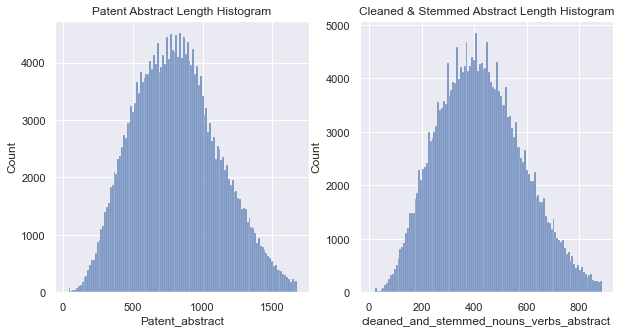

In [37]:
###Outliers are defined as data points that are more than 1.5 times the IQR away from the upper or lower quartile.
import seaborn as sns
import matplotlib.pyplot as plt

def draw_len_hist(ax, data, column):
    Q1 = data[column].str.len().quantile(0.25)
    Q3 = data[column].str.len().quantile(0.75)
    IQR = Q3 - Q1
    # Calculate the upper and lower bounds
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    # Filter out the outliers
    filtered_data = data.loc[data[column].str.len().between(lower_bound, upper_bound)]
    # Plot the histogram of the filtered data
    return sns.histplot(filtered_data[column].str.len(), ax=ax)

# Create a 1x2 grid of plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Draw histograms
draw_len_hist(ax1, pooling_patent_data, 'Patent_abstract')
draw_len_hist(ax2, pooling_patent_data, 'cleaned_and_stemmed_nouns_verbs_abstract')

# Set titles for the histograms
ax1.set_title('Patent Abstract Length Histogram')
ax2.set_title('Cleaned & Stemmed Abstract Length Histogram')

# Show the combined plots
plt.savefig(f'{results}/length.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# 2） Load a distance table

In [6]:
distance_tfidf_df = pd.read_csv(f'{workdata}/distance_tfidf_df.csv').set_index(['APPLN_ID_SIPO', 'PubNum_google'])
distance_tfidf_df = distance_tfidf_df.replace([float('inf')], pd.NA)
distance_tfidf_df_valid = distance_tfidf_df.dropna().reset_index()
distance_tfidf_df_valid.to_csv(f'{workdata}/distance_tfidf_df_valid.csv', index = False)
distance_tfidf_df_valid

,APPLN_ID_SIPO,PubNum_google,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN98118142.2,US5644677,1.414214,1.0,0.832555,1.0
1,CN98118142.2,KR100188089B,1.408604,0.992082,0.824432,0.980392
2,CN98118142.2,US5572591,1.387102,0.962025,0.812365,0.981481
3,CN98118142.2,JPH09322078,1.411895,0.996724,0.827688,0.984848
4,CN98118142.2,US5396560,1.414214,1.0,0.832555,1.0
...,...,...,...,...,...,...
255017,CN200710019949.6,CN1017887B,1.131257,0.639871,0.680472,0.8
255018,CN200710023249.4,CN2676102Y,1.266035,0.801423,0.731032,0.872093
255019,CN200710023249.4,CN201062869Y,0.694888,0.241435,0.478485,0.605634
255020,CN200710023249.4,US4955359A,0.967471,0.468,0.650876,0.860465


In [18]:
distance_df = pd.read_csv(f'{workdata}/distance_df.csv')
distance_df = distance_df.replace([float('inf')], pd.NA)
distance_df_valid = distance_df.drop(columns=['distance_pca_jensenshannon', 'distance_wbed_jensenshannon'])
distance_df_valid = distance_df_valid.dropna().reset_index(drop = True)
distance_df_valid.to_csv(f'{workdata}/distance_df_valid.csv', index = False)
distance_df_valid

,APPLN_ID_SIPO,PubNum_google,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine
0,CN98118142.2,US5644677,1.158632,0.983931,0.735256,0.49571,0.987218,8.046884,0.894533
1,CN98118142.2,KR100188089B,1.160848,0.984116,0.736094,0.516308,0.99796,7.24412,1.0195
2,CN98118142.2,US5572591,1.133489,0.981703,0.726175,0.847552,1.028149,7.978792,0.882985
3,CN98118142.2,JPH09322078,1.164768,0.98444,0.73759,0.672208,1.088952,9.08189,1.106969
4,CN98118142.2,US5396560,1.162612,0.984262,0.736764,0.422512,0.981984,7.853419,0.976801
...,...,...,...,...,...,...,...,...,...
255017,CN200710019949.6,CN1017887B,0.009509,0.000003,0.008768,0.141188,0.080943,2.807656,0.130073
255018,CN200710023249.4,CN2676102Y,0.384796,0.104343,0.31478,0.391238,0.411181,2.306281,0.074339
255019,CN200710023249.4,CN201062869Y,0.393024,0.104634,0.317174,0.145856,0.044098,1.355612,0.018861
255020,CN200710023249.4,US4955359A,0.364394,0.169634,0.199885,0.221151,0.066088,2.178215,0.065236


In [21]:
distance_df_combine = pd.merge(distance_df_valid, distance_tfidf_df_valid, on=['APPLN_ID_SIPO', 'PubNum_google'], how='left')
distance_df_combine.to_csv(f'{workdata}/distance_df_combine.csv', index = False)
distance_df_combine

,APPLN_ID_SIPO,PubNum_google,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN98118142.2,US5644677,1.158632,0.983931,0.735256,0.49571,0.987218,8.046884,0.894533,1.414214,1.0,0.832555,1.0
1,CN98118142.2,KR100188089B,1.160848,0.984116,0.736094,0.516308,0.99796,7.24412,1.0195,1.408604,0.992082,0.824432,0.980392
2,CN98118142.2,US5572591,1.133489,0.981703,0.726175,0.847552,1.028149,7.978792,0.882985,1.387102,0.962025,0.812365,0.981481
3,CN98118142.2,JPH09322078,1.164768,0.98444,0.73759,0.672208,1.088952,9.08189,1.106969,1.411895,0.996724,0.827688,0.984848
4,CN98118142.2,US5396560,1.162612,0.984262,0.736764,0.422512,0.981984,7.853419,0.976801,1.414214,1.0,0.832555,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255027,CN200710019949.6,CN1017887B,0.009509,0.000003,0.008768,0.141188,0.080943,2.807656,0.130073,1.131257,0.639871,0.680472,0.8
255028,CN200710023249.4,CN2676102Y,0.384796,0.104343,0.31478,0.391238,0.411181,2.306281,0.074339,1.266035,0.801423,0.731032,0.872093
255029,CN200710023249.4,CN201062869Y,0.393024,0.104634,0.317174,0.145856,0.044098,1.355612,0.018861,0.694888,0.241435,0.478485,0.605634
255030,CN200710023249.4,US4955359A,0.364394,0.169634,0.199885,0.221151,0.066088,2.178215,0.065236,0.967471,0.468,0.650876,0.860465


# 3) compare the corr of diff measurement: 

In [32]:
column_names = ["ID", "APPLN_ID_SIPO", "PubNum_google", "distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon", "distance_pca_euclidean", "distance_pca_cosine", "distance_wbed_euclidean", "distance_wbed_cosine", "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]
distance_df_matrix = pd.DataFrame(distance_df_combine, columns=column_names)

# Convert columns to numeric data types
numeric_columns = ["distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
                   "distance_pca_euclidean", "distance_pca_cosine",
                   "distance_wbed_euclidean", "distance_wbed_cosine",
                   "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

for col in numeric_columns:
    distance_df_matrix[col] = pd.to_numeric(distance_df_matrix[col], errors='coerce')

# Calculate the correlation matrix
corr_matrix = distance_df_matrix.loc[:, numeric_columns].corr()
pd.DataFrame(corr_matrix)


,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
distance_lda_euclidean,1.000000,0.976998,0.988964,0.219680,0.353806,0.322114,0.302742,0.320896,0.342168,0.318422,0.266398
distance_lda_cosine,0.976998,1.000000,0.972724,0.221984,0.367201,0.336528,0.319205,0.320468,0.346409,0.316517,0.262746
distance_lda_jensenshannon,0.988964,0.972724,1.000000,0.217787,0.363720,0.329032,0.312987,0.328553,0.349290,0.327961,0.277169
distance_pca_euclidean,0.219680,0.221984,0.217787,1.000000,0.634697,0.198208,0.039527,0.335032,0.330192,0.304669,0.222153
distance_pca_cosine,0.353806,0.367201,0.363720,0.634697,1.000000,0.460445,0.396734,0.502652,0.540225,0.511827,0.423845
distance_wbed_euclidean,0.322114,0.336528,0.329032,0.198208,0.460445,1.000000,0.879796,0.435811,0.445826,0.523696,0.553347
distance_wbed_cosine,0.302742,0.319205,0.312987,0.039527,0.396734,0.879796,1.000000,0.338729,0.374220,0.407086,0.426799
distance_tfidf_euclidean,0.320896,0.320468,0.328553,0.335032,0.502652,0.435811,0.338729,1.000000,0.973534,0.926802,0.742326
distance_tfidf_cosine,0.342168,0.346409,0.349290,0.330192,0.540225,0.445826,0.374220,0.973534,1.000000,0.866979,0.657853
distance_tfidf_jensenshannon,0.318422,0.316517,0.327961,0.304669,0.511827,0.523696,0.407086,0.926802,0.866979,1.000000,0.923969


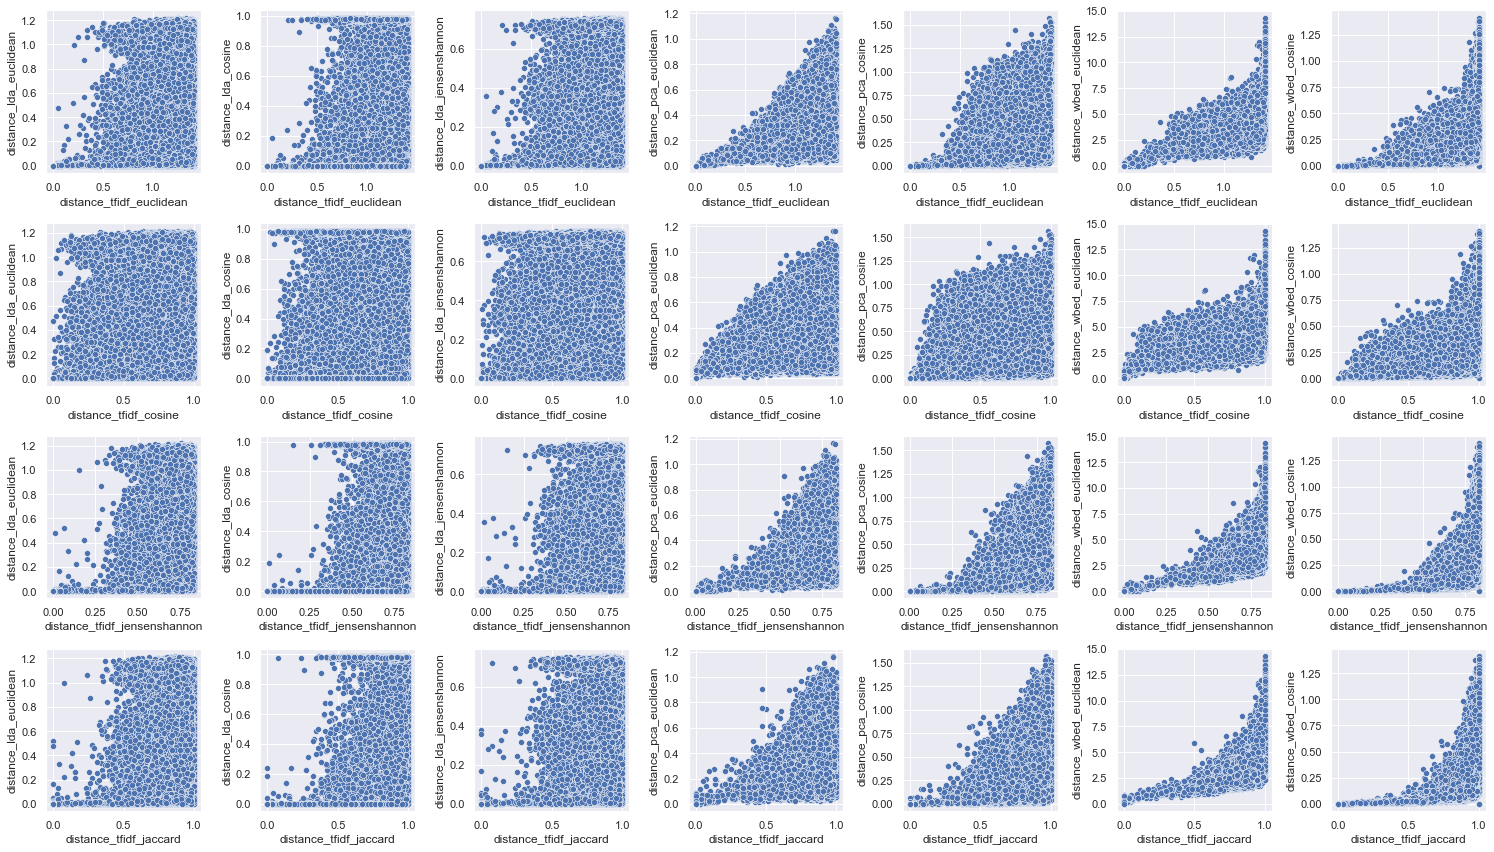

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

x_columns = [
    "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

y_columns = [
    "distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
    "distance_pca_euclidean", "distance_pca_cosine",
    "distance_wbed_euclidean", "distance_wbed_cosine"]

# Create a 4x7 grid of scatter plots
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(21, 12))

for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        sns.scatterplot(data=distance_df_matrix, x=x_col, y=y_col, ax=axes[i, j])
        axes[i, j].set_xlabel(x_col)
        axes[i, j].set_ylabel(y_col)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(f'{results}/corr_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# 4) Find the most close patent & average distance to their citation:

In [39]:
columns_to_minimize = numeric_columns
closest_pubnums = {}

for col in columns_to_minimize:
    # Group by 'APPLN_ID_SIPO' and find the index of the minimum value in the current column
    min_indices = distance_df_matrix.groupby('APPLN_ID_SIPO')[col].idxmin()

    # Select the rows with the minium values in the current column
    closest_pubnums_col = distance_df_matrix.loc[min_indices, ['APPLN_ID_SIPO', 'PubNum_google', col]]

    # Set 'APPLN_ID_SIPO' as the index
    closest_pubnums_col.set_index('APPLN_ID_SIPO', inplace=True)

    # Rename the columns
    closest_pubnums_col.columns = [f'PubNum_{col}', f'{col}_min']

    # Store the result in the dictionary
    closest_pubnums[col] = closest_pubnums_col

# Concatenate the data frames in the dictionary
closest_pubnums_combined = pd.concat(closest_pubnums.values(), axis=1)

# Write the concatenated data frame to a CSV file
closest_pubnums_combined.to_csv(f'{workdata}/closest_pubnums_combined.csv',index= True)

In [40]:
closest_pubnums_combined

,PubNum_distance_lda_euclidean,distance_lda_euclidean_min,PubNum_distance_lda_cosine,distance_lda_cosine_min,PubNum_distance_lda_jensenshannon,distance_lda_jensenshannon_min,PubNum_distance_pca_euclidean,distance_pca_euclidean_min,PubNum_distance_pca_cosine,distance_pca_cosine_min,...,PubNum_distance_wbed_cosine,distance_wbed_cosine_min,PubNum_distance_tfidf_euclidean,distance_tfidf_euclidean_min,PubNum_distance_tfidf_cosine,distance_tfidf_cosine_min,PubNum_distance_tfidf_jensenshannon,distance_tfidf_jensenshannon_min,PubNum_distance_tfidf_jaccard,distance_tfidf_jaccard_min
APPLN_ID_SIPO,,,,,,,,,,,,,,,,,,,,,
CN00100006.3,US6032845A,1.025020,US6032845A,0.979912,US4887778,0.730552,US6032845A,0.339120,US6032845A,0.526583,...,US4887778,0.203622,US6032845A,1.355133,US6032845A,0.918193,US6032845A,0.780191,US5024720A,0.916667
CN00100115.9,JPH026402A,0.615108,JPH026402A,0.312296,JPH026402A,0.420874,CN1210673A,0.226566,CN1210673A,0.217691,...,JPH10324608A,0.125016,CN1210673A,1.151594,CN1210673A,0.663085,CN1210673A,0.674064,CN1210673A,0.816327
CN00100212.0,US5754512A,0.982141,US5754512A,0.974674,JPH097217A,0.711114,JPH097217A,0.240275,JPH097217A,0.685415,...,US5130857A,0.346470,JPH08278477A,1.395319,JPH08278477A,0.973458,JPH08278477A,0.811505,JPH08278477A,0.965517
CN00100269.4,US20020168307A1,0.993517,US20020168307A1,0.975987,US20020168307A1,0.722987,US6296814B,0.232332,US20020168307A1,0.560925,...,JPS6054902A,0.555768,CN1292157A,1.402198,CN1292157A,0.983080,CN1292157A,0.818794,CN1292157A,0.973684
CN00100304.6,CN1230924A,0.587417,JPS63110003A,0.558537,JPS63110003A,0.526009,JPS63110003A,0.238625,JPS63110003A,0.677291,...,EP0635383A1,0.225288,EP0635383A1,1.404327,EP0635383A1,0.986067,EP0635383A1,0.819322,CN1230924A,0.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CN99127239.0,US4959463A,0.975378,US4973679A,0.971182,US5705621A,0.697617,US6768005B2,0.206742,US6768005B2,0.497793,...,US5132418A,0.437947,WO1994001446A2,1.390784,WO1994001446A2,0.967140,WO1994001446A2,0.808760,US5554746A,0.950000
CN99127261.7,CN1138929A,1.001529,CN1138929A,0.977300,US5777544A,0.714812,US5777544A,0.394691,CN1248376A,1.084906,...,CN1248376A,0.820338,CN1138929A,1.401343,CN1138929A,0.981881,CN1138929A,0.810599,CN1138929A,0.950000
CN99127312.5,JPS5718522A,1.105338,JPS5718522A,0.979181,JPS5718522A,0.714649,JPH11342793A,0.172845,JPH11342793A,0.826053,...,JPH11342793A,0.373001,US4779917A,1.414214,GB878015A,1.000000,GB878015A,0.832555,GB878015A,1.000000


In [42]:
closest_pubnums_combined.columns

Index(['PubNum_distance_lda_euclidean', 'distance_lda_euclidean_min',
       'PubNum_distance_lda_cosine', 'distance_lda_cosine_min',
       'PubNum_distance_lda_jensenshannon', 'distance_lda_jensenshannon_min',
       'PubNum_distance_pca_euclidean', 'distance_pca_euclidean_min',
       'PubNum_distance_pca_cosine', 'distance_pca_cosine_min',
       'PubNum_distance_wbed_euclidean', 'distance_wbed_euclidean_min',
       'PubNum_distance_wbed_cosine', 'distance_wbed_cosine_min',
       'PubNum_distance_tfidf_euclidean', 'distance_tfidf_euclidean_min',
       'PubNum_distance_tfidf_cosine', 'distance_tfidf_cosine_min',
       'PubNum_distance_tfidf_jensenshannon',
       'distance_tfidf_jensenshannon_min', 'PubNum_distance_tfidf_jaccard',
       'distance_tfidf_jaccard_min'],
      dtype='object')

In [43]:
closest_pubnums = closest_pubnums_combined[['PubNum_distance_lda_euclidean','PubNum_distance_lda_cosine', 'PubNum_distance_lda_jensenshannon', 
                                            'PubNum_distance_pca_euclidean', 'PubNum_distance_pca_cosine', 
                                            'PubNum_distance_wbed_euclidean', 'PubNum_distance_wbed_cosine', 
                                            'PubNum_distance_tfidf_euclidean', 'PubNum_distance_tfidf_cosine', 'PubNum_distance_tfidf_jensenshannon','PubNum_distance_tfidf_jaccard']]
closest_pubnums.to_csv(f'{workdata}/closest_pubnums.csv',index= True)

closest_distances = closest_pubnums_combined[['distance_lda_euclidean_min','distance_lda_cosine_min', 'distance_lda_jensenshannon_min', 
                                              'distance_pca_euclidean_min', 'distance_pca_cosine_min',
                                              'distance_wbed_cosine_min', 'distance_wbed_euclidean_min', 
                                            'distance_tfidf_euclidean_min','distance_tfidf_cosine_min', 'distance_tfidf_jensenshannon_min', 'distance_tfidf_jaccard_min']]
closest_distances.to_csv(f'{workdata}/closest_distances.csv',index= True)

In [19]:
distance_df_combine = pd.read_csv(f'{workdata}/distance_df_combine.csv')

In [21]:
columns_to_average = ["distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
                   "distance_pca_euclidean", "distance_pca_cosine",
                   "distance_wbed_euclidean", "distance_wbed_cosine",
                   "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

grouped_averages = distance_df_combine.groupby('APPLN_ID_SIPO')[columns_to_average].mean()
grouped_averages_ave = grouped_averages.add_suffix('_ave')
grouped_averages_ave = pd.DataFrame(grouped_averages_ave)
grouped_averages_ave.to_csv(f'{workdata}/grouped_averages_ave.csv',index= True)
grouped_averages_ave

,distance_lda_euclidean_ave,distance_lda_cosine_ave,distance_lda_jensenshannon_ave,distance_pca_euclidean_ave,distance_pca_cosine_ave,distance_wbed_euclidean_ave,distance_wbed_cosine_ave,distance_tfidf_euclidean_ave,distance_tfidf_cosine_ave,distance_tfidf_jensenshannon_ave,distance_tfidf_jaccard_ave
APPLN_ID_SIPO,,,,,,,,,,,
CN00100006.3,1.130822,0.983338,0.738137,0.393502,0.779718,4.065451,0.232735,1.377777,0.949233,0.795857,0.937625
CN00100115.9,0.891757,0.756854,0.629094,0.289622,0.288887,2.839274,0.142826,1.276471,0.818821,0.731923,0.858601
CN00100212.0,1.113444,0.980575,0.722725,0.301600,0.918801,5.591383,0.539392,1.411948,0.996813,0.829238,0.991700
CN00100269.4,1.098381,0.981651,0.733125,0.321938,0.800254,5.339692,0.612386,1.408931,0.992554,0.826202,0.987372
CN00100304.6,0.744956,0.747281,0.609321,0.292851,0.784914,3.915873,0.293085,1.411821,0.996626,0.828204,0.987678
...,...,...,...,...,...,...,...,...,...,...,...
CN99127239.0,1.090608,0.978761,0.717013,0.312199,0.995815,7.440416,0.757232,1.410895,0.995324,0.827042,0.984821
CN99127261.7,1.105594,0.980374,0.722704,0.532974,1.237677,8.958733,0.927563,1.409565,0.993447,0.824254,0.978364
CN99127312.5,1.128922,0.981342,0.723799,0.225715,0.956300,6.065336,0.555724,1.414214,1.000000,0.832555,1.000000


# 5) choose a patent and show the distance network:

In [7]:
distance_df_combine = pd.read_csv(f'{workdata}/distance_df_combine.csv').set_index(['APPLN_ID_SIPO', 'PubNum_google'])
distance_df_pair_ave = distance_df_combine.mean(axis=1)
distance_df_pair_ave = distance_df_pair_ave.to_frame(name='average_distance')
distance_df_pair_ave.reset_index(inplace=True)
distance_df_pair_ave.to_csv(f'{workdata}/distance_df_pair_ave.csv',index= False)
distance_df_pair_ave

,APPLN_ID_SIPO,PubNum_google,average_distance
0,CN98118142.2,US5644677,1.595357
1,CN98118142.2,KR100188089B,1.533132
2,CN98118142.2,US5572591,1.611074
3,CN98118142.2,JPH09322078,1.732543
4,CN98118142.2,US5396560,1.578647
...,...,...,...
255027,CN200710019949.6,CN1017887B,0.584522
255028,CN200710023249.4,CN2676102Y,0.696140
255029,CN200710023249.4,CN201062869Y,0.399973
255030,CN200710023249.4,US4955359A,0.564674


In [9]:
# pip install ipywidgets

In [10]:
distance_df_pair_ave = pd.read_csv(f'{workdata}/distance_df_pair_ave.csv')

In [13]:
import ipywidgets as widgets
from IPython.display import display

def plot_graph(appln_id_sipo):
    selected_rows = distance_df_pair_ave[distance_df_pair_ave['APPLN_ID_SIPO'] == appln_id_sipo]
    
    # Create an empty graph
    G = nx.Graph()

    # Add edges to the graph from the DataFrame
    for _, row in selected_rows.iterrows():
        G.add_edge(row['APPLN_ID_SIPO'], row['PubNum_google'], weight=row['average_distance'])

    # Draw the network graph
    plt.figure(figsize=(12, 12))
    pos = nx.kamada_kawai_layout(G, weight='weight')

    # Apply colors to the nodes and edges
    node_colors = [node_color(node) for node in G.nodes]
    edge_colors = [edge_color(u, v) for u, v in G.edges]

    nx.draw(G, pos, node_size=50, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=0.5)

    plt.tight_layout()
    plt.show()

appln_id_sipo_values = ['CN01108152.X', 'CN98113483.1', 'CN201110039138.9']

dropdown = widgets.Dropdown(
    options=appln_id_sipo_values,
    value=appln_id_sipo_values[0],
    description='APPLN_ID_SIPO:',
)

interactive_plot = widgets.interactive(plot_graph, appln_id_sipo=dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='APPLN_ID_SIPO:', options=('CN01108152.X', 'CN98113483.1', 'CN20111…

# 6) Sentiment Analysis: 

In [6]:
sentiment_and_emotions_df = pd.read_csv(f'{workdata}/sentiment_and_emotions_df.csv')
sentiment_and_emotions_df

,Patent_ID,Sentiment_Polarity,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,CN2591665Y,-0.040705,1,0,3,0,3,3,3,1,6
1,US6380449B1,-0.209375,0,0,0,0,0,1,0,0,0
2,CN1420491A,0.000000,0,0,0,0,0,3,0,0,2
3,CN200410000774.0,0.000000,0,0,0,0,0,1,0,0,0
4,CN200710018012.7,-0.075000,0,0,1,0,1,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...
195,JPH10136328A,0.133333,0,0,1,0,1,0,1,0,2
196,EP1316792A2,0.135417,0,0,0,0,0,0,0,0,0
197,US6738363B1,0.130682,1,0,0,1,0,1,0,0,2
198,CN1427591A,0.083333,0,0,0,0,0,0,0,0,0


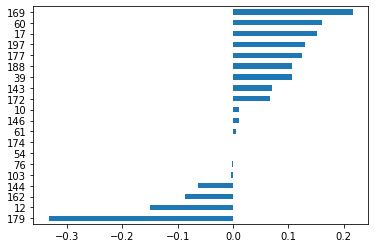

In [14]:
sentiment_and_emotions_df['Sentiment_Polarity'].sample(20).sort_values().plot.barh();